In [1]:
suppressPackageStartupMessages(
    {suppressWarnings({
        library(tidyverse)
        library(repr)
        library(tidymodels)
        library(GGally)
        library(gridExtra)
        library(grid)
        library(tidyr)
    })
})
    

In [2]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.matrix.max.rows = 7,readr.show_col_types = FALSE)

player_data <- read_csv("data/players.csv")
session_data <- read_csv("data/sessions.csv")



In [3]:
ply_summarised_num <- player_data |>
                summarise(subscribed_percent_decimal = mean(subscribe),
                       played_hours_avg = mean(played_hours),
                       played_hours_median = median(played_hours),
                       played_hours_max = max(played_hours),
                       played_hours_min = min(played_hours),
                       age_avg =  mean(Age, na.rm = TRUE), 
                       age_median = median(Age, na.rm = TRUE),
                       age_max = max(Age,  na.rm = TRUE), 
                        age_min = min(Age,  na.rm = TRUE)) |>
                        select(subscribed_percent_decimal,played_hours_avg,played_hours_median, played_hours_max, played_hours_min,age_avg,age_median, age_max, ) |>
                        round(2)

ply_summarised_gender <- player_data |>
                        select(gender) |>
                        count(gender) |>
                        mutate(percent_decimal = round(n /sum(n), 2)) |>
                        rename(count = n)

ply_summarised_experience <- player_data |>
                        select(experience) |>
                        count(experience) |>
                        mutate(percent_decimal = round(n /sum(n), 2)) |>
                        rename(count = n)


# **Data Science Project: Planning Stage**

## **(1) Data Description:**
Samples were collected from the plaicraft.ai website through volunteer sign-up, where participants provided their email addresses, phone numbers, and personal details to participate.

#### **Player Data:** 
Observations: 196 

Variables: 7 

  - `experience` \<char> player gaming experience, `Beginner`, `Amateur`, `Regular`, `Veteran`, `Pro`.
  - `subscribe` \<Boolean> newsletter subscription status, `TRUE` or `FALSE`.
  - `hashedEmail` \<char> unique player data ID.
  - `played_hours` \<double> total hours spent playing on server.
  - `name` \<char> player first name.
  - `gender` \<char> gender identifier, `Male`, `Female`, `Non-binary`, `Prefer not to say`, `Agender`, `Two-Spirited`, `Other`.
  - `Age` \<double> age in years.

#### General Stats:

In [4]:
ply_summarised_num

subscribed_percent_decimal,played_hours_avg,played_hours_median,played_hours_max,played_hours_min,age_avg,age_median,age_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.73,5.85,0.1,223.1,0,21.14,19,58


#### Gender Stats:

In [5]:
ply_summarised_gender

gender,count,percent_decimal
<chr>,<int>,<dbl>
Agender,2,0.01
Female,37,0.19
Male,124,0.63
Non-binary,15,0.08
Other,1,0.01
Prefer not to say,11,0.06
Two-Spirited,6,0.03


#### Experience Stats:

In [6]:
ply_summarised_experience

experience,count,percent_decimal
<chr>,<int>,<dbl>
Amateur,63,0.32
Beginner,35,0.18
Pro,14,0.07
Regular,36,0.18
Veteran,48,0.24


#### Potential Issues:
- Missing values in `Age`.
- Players with 0 `played_hours` and dominant male-identifying participants could skew results.
- Risk of volunteer bias.

In [7]:
distinct_players <- session_data |>
                    select(hashedEmail) |>
                    n_distinct()
total_visits <- session_data |>
                nrow()
players_count <- session_data |>
                        select(hashedEmail) |>
                        count(hashedEmail) |>
                        rename(count = n) |>
                        select(count) 

player_single_visit <-  players_count |> 
                            select(count) |> 
                            filter(count == 1) |>
                            nrow()
                        

session_stats <- players_count |>
                summarise(
                    count_player_max_visits = max(count),
                    count_player_min_visits = min(count)
                ) |>
                mutate(distinct_players = distinct_players, 
                       num_player_single_visit = player_single_visit, total_visits = total_visits) |>
                select(total_visits, distinct_players, 
                       num_player_single_visit, count_player_max_visits, 
                       count_player_min_visits)



#### **Session Data:**
Observations: 1535 

Variables: 5 
- `hashedEmail` \<char> unique hash data ID per player.
  
Sessions:
- `start_time` \<char> start date and military time.
- `end_time` \<char> end date and military time.
- `original_start_time` \<char> precise start time (milliseconds).
- `original_end_time` \<char> precise end time (milliseconds).


#### Session Stats:

In [8]:
session_stats

total_visits,distinct_players,num_player_single_visit,count_player_max_visits,count_player_min_visits
<int>,<int>,<int>,<int>,<int>
1535,125,81,310,1


#### Potential Issues:
- Singular date/time variable complicates analysis.
- All variables are in char; conversion required for numerical analysis.
- Only 125 of 196 players have session data, which may skew results from `played_hours`.

### **(2) Questions:**
Which player characteristics and behaviours best predict subscription to a game-related newsletter, and how do these differ among player types?

What players' `Age`, `gender`, and `played_hours` can best predict whether they would `subscribe` to a gaming newsletter, and how does it differ from players `experience`?


Using bucketed Age and gender variables will help isolate player characteristics that result in most likely subscription. Player's behaviour, play_hours, see how time spent playing on the server correlates with subscribing. We can further evaluate how these resulting subscriptions from characteristics and behaviours behave based on their gaming `experience`.

### **(3) Exploratory Data Analysis and Visualization:**

gender,experience,Age,played_hours,subscribe
<chr>,<chr>,<dbl>,<dbl>,<lgl>
Male,Pro,9,30.3,TRUE
Male,Veteran,17,3.8,TRUE
Male,Veteran,17,0.0,FALSE
Female,Amateur,21,0.7,TRUE
⋮,⋮,⋮,⋮,⋮
Male,Veteran,22,0.3,FALSE
Prefer not to say,Amateur,57,0.0,FALSE
Male,Amateur,17,2.3,FALSE


player_hours_mean,player_age_mean
<dbl>,<dbl>
5.9,21.14


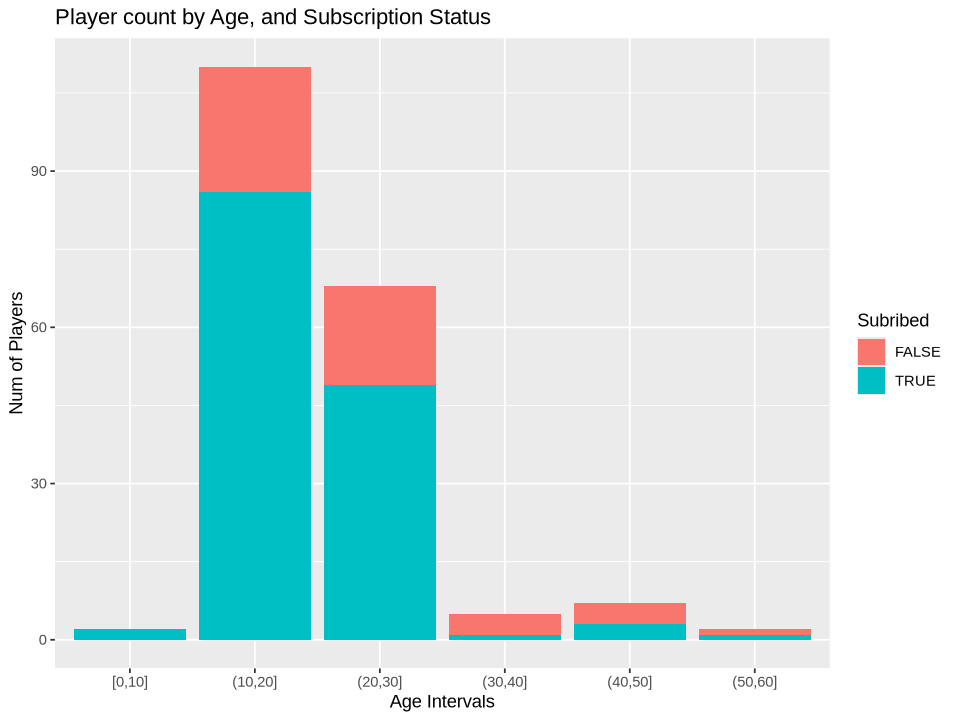

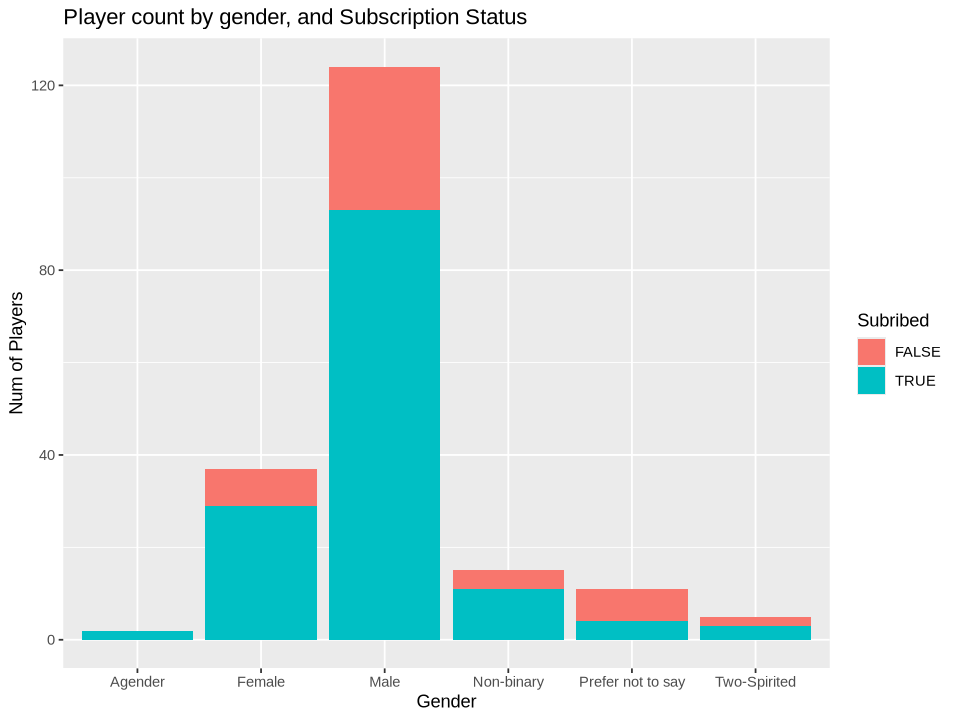

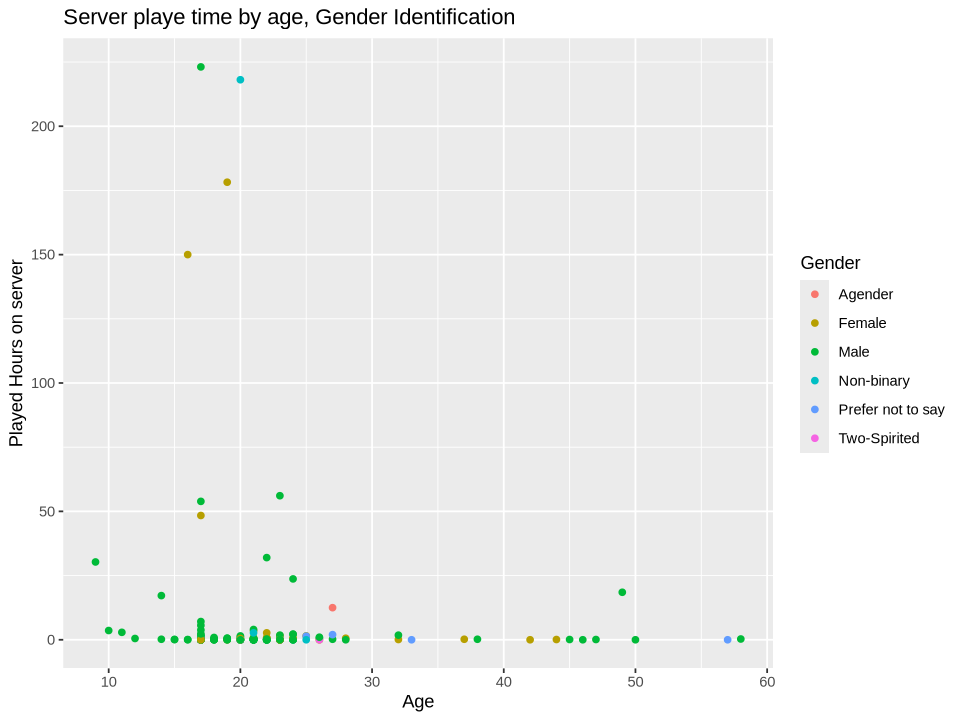

In [120]:
options(repr.plot.width = 8, repr.plot.height = 6)


# player_data
player_wraggled <- player_data |>
            select(gender, experience, Age, played_hours, subscribe) |>
            drop_na()

player_wraggled

player_means_minimal <- player_wraggled |> 
            select(played_hours, Age) |>
            summarize(player_hours_mean = mean(played_hours), player_age_mean = mean(Age)) |>
            round(2)

player_means_minimal
player_age_buckets <- player_wraggled |>
                mutate(age_intervel = cut_interval(Age, length = 10)) 

sub_count <- player_age_buckets |>
            count(subscribe, age_intervel) 
# sub_count
sub_age_bar <- sub_count |>
            ggplot(aes( x = age_intervel , y = n, fill = subscribe)) +
            geom_bar(stat = "identity") +
            ggtitle("Player count by Age, and Subscription Status") + 
            labs(x = "Age Intervals", y = "Num of Players", fill = "Subribed")

sub_age_bar


gender_age_count <- player_age_buckets |>
                select(subscribe, gender) |>
                 count(subscribe, gender) 

gender_age_bar <- gender_age_count |>
            ggplot(aes( x = gender , y = n, fill = subscribe)) +
            geom_bar(stat = "identity") +
            ggtitle("Player count by gender, and Subscription Status") + 
            labs(x = "Gender", y = "Num of Players", fill = "Subribed")      

gender_age_bar
# TODO: x age, y hours legen sub

age_hours_point <- player_wraggled |>
                ggplot(aes( x = Age, y= played_hours, colour = gender)) + 
                geom_point(stat = "identity") +
                ggtitle("Server playe time by age, Gender Identification") +
                labs(x= "Age", y ="Played Hours on server", colour ="Gender")

age_hours_point
# TODO: x age, y hours legen gender


# TODO: bar plot exper vs sub



### **(4) Methods and Plan:**